In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from utils import *
import matplotlib.pyplot as plt
import csv
import time

In [27]:

# Quantization function
def quantize(tensor, bits):
    scale = 2**bits - 1
    tensor = torch.round(tensor * scale) / scale
    return tensor

In [28]:

# Setup logging
log_file = 'training_log.csv'
with open(log_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train Loss', 'Test Loss'])



In [29]:
def train(model, num_epochs,compress_function=None, input_compress_settings=None):

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

  # Lists to store metrics
  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []

    # Track time and memory
  start_time = time.time()
  initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else None

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for inputs, targets in trainloader:
          inputs, targets = inputs.cuda(), targets.cuda()

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()

          # Apply gradient compression
          if compress_function is not None and input_compress_settings is not None:
              for param in model.parameters():
                  if param.grad is not None:
                      param.grad.data = compress_function(param.grad.data, input_compress_settings)

          optimizer.step()
          running_loss += loss.item()

      print(f'Epoch {epoch + 1}, Train_Loss: {running_loss / len(trainloader)}')
      train_losses.append(running_loss / len(trainloader))

      # Validate the model
      model.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for inputs, targets in testloader:
              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              test_loss += loss.item()
              _, predicted = torch.max(outputs, 1)
              total += targets.size(0)
              correct += (predicted == targets).sum().item()

      print(f'Epoch {epoch + 1}, Test_Loss: {test_loss / len(testloader)}')
      test_losses.append(test_loss / len(testloader))
      print(f'Accuracy: {100 * correct / total}%')
      test_accuracies.append(100 * correct / total)
      print("###########################################")

  print('Finished Training')
  end_time = time.time()
  total_time = end_time - start_time
  final_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else None
  memory_consumed = final_memory - initial_memory if torch.cuda.is_available() else None

  print('Finished Training')
  print(f'Total Training Time: {total_time:.2f} seconds')
  if torch.cuda.is_available():
    print(f'Memory Consumed: {memory_consumed / (1024 ** 2):.2f} MB')  # Convert bytes to MB

  return train_losses, test_losses, test_accuracies


In [30]:
# Function to plot the metrics
def plot_metrics(train_losses, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, test_losses, 'r', label='Test loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    # plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()



# ResNet Experiments on CIFAR

In [31]:

# CIFAR-10 data loading and transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Epoch 1, Train_Loss: 5.061803536646811
Epoch 1, Test_Loss: 2.8539624214172363
Accuracy: 11.61%
###########################################
Epoch 2, Train_Loss: 2.5077672455926687
Epoch 2, Test_Loss: 2.36328973951219
Accuracy: 13.02%
###########################################
Epoch 3, Train_Loss: 2.321290243617104
Epoch 3, Test_Loss: 2.2867601762844036
Accuracy: 12.82%
###########################################
Epoch 4, Train_Loss: 2.2872782588919716
Epoch 4, Test_Loss: 2.2869724050352844
Accuracy: 12.93%
###########################################
Epoch 5, Train_Loss: 2.2857971758488804
Epoch 5, Test_Loss: 2.2827533709852
Accuracy: 12.79%
###########################################
Epoch 6, Train_Loss: 2.2844797052690744
Epoch 6, Test_Loss: 2.290820197214054
Accuracy: 12.01%
###########################################
Epoch 7, Train_Loss: 2.291116022392917
Epoch 7, Test_Loss: 2.2919954136957097
Accuracy: 10.68%
###########################################
Epoch 8, Train_Loss: 2.296403

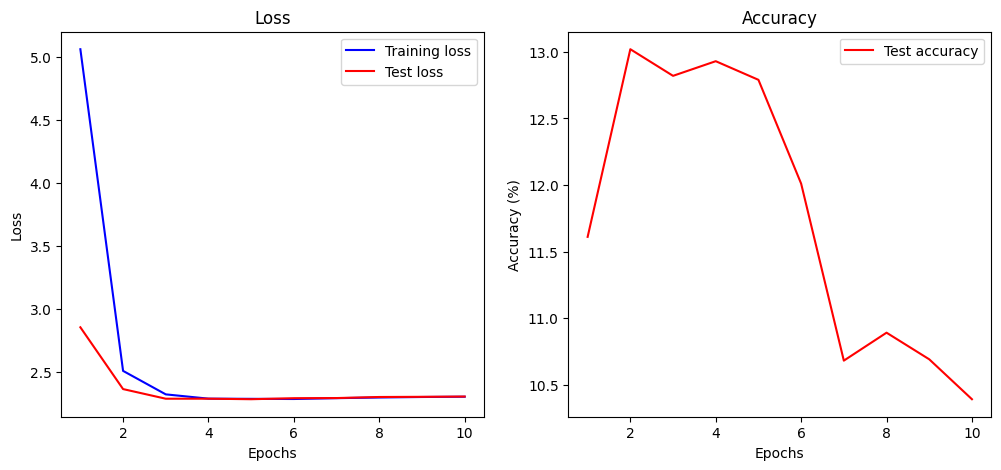

In [32]:
num_epochs = 10
input_compress_settings = 2 # Adjust this for different levels of quantization
compress_function = quantize
from torchvision import datasets, transforms, models
# Define the model
model = models.resnet18(num_classes=10)
model = model.cuda()

#train
train_losses, test_losses, test_accuracies = train(model, num_epochs, compress_function, input_compress_settings)

# Plot the metrics
plot_metrics(train_losses, test_losses, test_accuracies)

Epoch 1, Train_Loss: 1.9604502416327787
Epoch 1, Test_Loss: 1.40762558013578
Accuracy: 48.99%
###########################################
Epoch 2, Train_Loss: 1.2814747032607
Epoch 2, Test_Loss: 1.1667908083034466
Accuracy: 57.51%
###########################################
Epoch 3, Train_Loss: 1.046887546853946
Epoch 3, Test_Loss: 1.0227606462526926
Accuracy: 63.52%
###########################################
Epoch 4, Train_Loss: 0.9072707955489683
Epoch 4, Test_Loss: 0.9879065159755417
Accuracy: 65.22%
###########################################
Epoch 5, Train_Loss: 0.8042288802163985
Epoch 5, Test_Loss: 0.8692442276809789
Accuracy: 69.84%
###########################################
Epoch 6, Train_Loss: 0.7426718337761472
Epoch 6, Test_Loss: 0.9051911672459373
Accuracy: 68.95%
###########################################
Epoch 7, Train_Loss: 0.6805559825104521
Epoch 7, Test_Loss: 0.8520565629005432
Accuracy: 70.81%
###########################################
Epoch 8, Train_Loss: 0.640

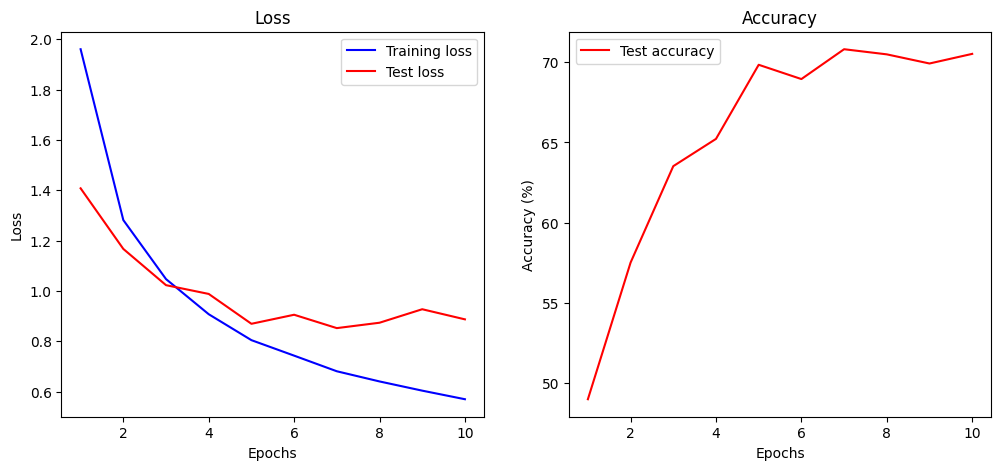

In [35]:
num_epochs = 10
input_compress_settings = None # Adjust this for different levels of quantization
compress_function = quantize
from torchvision import datasets, transforms, models
# Define the model
model = models.resnet18(num_classes=10)
model = model.cuda()

#train
train_losses, test_losses, test_accuracies = train(model, num_epochs, compress_function, input_compress_settings)

# Plot the metrics
plot_metrics(train_losses, test_losses, test_accuracies)

In [ ]:
num_epochs = 10
input_compress_settings = 8 # Adjust this for different levels of quantization
compress_function = quantize
from torchvision import datasets, transforms, models
# Define the model
model = models.resnet18(num_classes=10)
model = model.cuda()

#train
train_losses, test_losses, test_accuracies = train(model, num_epochs, compress_function, input_compress_settings)

# Plot the metrics
plot_metrics(train_losses, test_losses, test_accuracies)

In [ ]:
num_epochs = 10
input_compress_settings = {'k': 1/32} # Adjust this for different levels of quantization

from torchvision import datasets, transforms, models
# Define the model
model = models.resnet18(num_classes=10)
model = model.cuda()

#train
train_losses, test_losses, test_accuracies = train(model, num_epochs, sparse_top_k, input_compress_settings)

# Plot the metrics
plot_metrics(train_losses, test_losses, test_accuracies)

In [ ]:
num_epochs = 50
input_compress_settings = None # Adjust this for different levels of quantization
compress_function=None

from torchvision import datasets, transforms, models
# Define the model
model = models.resnet18(num_classes=10)
model = model.cuda()

#train
train_losses, test_losses, test_accuracies = train(model, num_epochs, compress_function, input_compress_settings)

# Plot the metrics
plot_metrics(train_losses, test_losses, test_accuracies)

# Perceptron Experiments on IRIS



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define the Perceptron model
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Hyperparameters
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))
print(input_dim)
print(output_dim)
learning_rate = 0.01
num_epochs = 1000

# Initialize the model, loss function, and optimizer
model = Perceptron(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    # for param in model.parameters():
    #   if param.grad is not None:
    #       param.grad.data = quantize(param.grad.data, 2)
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Finished Training')

# Evaluation
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)
    train_accuracy = accuracy_score(y_train, train_predicted) * 100

    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test, test_predicted) * 100

print(f'Training Accuracy: {train_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')